In [ ]:
import time
startTime = time.time()

In [ ]:
########## Chapter 3 - IMPLEMENTATION ##########

In [ ]:
# Import Dependencies
# NUMPY #
#Numpy = python library used for scientific computing 
#that provides a multidimensional array object, various derived objects
#and routines for fast operations on arrays
import numpy as np
from numpy import array
# NUMPY #

# PANDAS #
#Pandas = higl-level building block for doing practical, real word
#data analysis in Python
import pandas as pd
import pandas_datareader as pdr
# PANDAS #

# DATETIME #
#Handle time related tasks
import datetime as dt
# DATETIME #

# SCI-KIT LEARN #
#Sklearn = tools for predictive data analysis
#MinMaxScaler = transforms features by scaleing each feature to a given range
from sklearn.preprocessing import MinMaxScaler
# SCI-KIT LEARN #

# TENSORFLOW #
#Tensorflow = open source platform for machine learning
#Keras = Deep learning API
#Sequential mocel is appropiate for stack of layers with one input and output
#Dense = Neural Network layer
#Dropout = randomly sets input units to 0 at each step during training
#Dropout prevents overfitting
#LSTM = long short term memory layer
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
# TENSORFLOW #

# MEAN SQUARED ERROR #
# Metric to monitor model's performance
from sklearn.metrics import mean_squared_error
# MEAN SQUARED ERROR #

# MATPLOTLIB #
#Creating static, animated and interactive plots in python 
import matplotlib.pyplot as plt
# MATPLOTLIB #

# Needed to install and import yahoo finance API
#because the DataReader was not working anymore(4 July 2021)
!pip install yfinance
import yfinance as yf

In [ ]:
#Company Historical Data Collector Method
#With the use of the company ticker and the starting date of the first listing it will
#return train, test and date data sets for the specified ticker
#Train: 80% of the whole, Test: 20% of the whole, Date: Full Set
#Note: The train/test sets will contain the closing price values of the company
#      The date set will contain the dates assigned to each share price
def companyDS(ticker, startDate):
  print("Company Ticker Symbol: ", ticker)
  ticker_full_DS = yf.download(ticker, startDate, dt.datetime.now())
  #ticker_full_DS = pdr.DataReader(ticker, 'yahoo', startDate, dt.datetime.now())
  ticker_date_DS = ticker_full_DS.reset_index()['Date']

  ticker_len = len(ticker_full_DS)
  trainsplit = 0.8 * ticker_len
  trainsplit = int(round(trainsplit,0))

  ticker_train_date = ticker_date_DS[trainsplit]

  #ticker_train_DS = pdr.DataReader(ticker, 'yahoo', startDate, ticker_train_date)
  ticker_train_DS = yf.download(ticker, startDate, ticker_train_date)
  ticker_train_DS = ticker_train_DS.reset_index()['Close']

  #ticker_test_DS = pdr.DataReader("INTC", 'yahoo', ticker_train_date, dt.datetime.now())
  ticker_test_DS = yf.download(ticker, ticker_train_date, dt.datetime.now())
  ticker_test_DS = ticker_test_DS.reset_index()['Close'].values
  return ticker_train_DS, ticker_test_DS, ticker_date_DS

In [ ]:
#Builds xtrain/ytrain sets in order to train the model
# WARNING!!! Scale the train_set to (-1,1) before using the function
def trainBuild(train_set):
  xtrain = []
  ytrain = []
  for i in range(pastDays, len(train_set)):
    xtrain.append(train_set[i-pastDays:i,0])
    ytrain.append(train_set[i,0])

  xtrain, ytrain = np.array(xtrain), np.array(ytrain)
  xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1],1))
  return xtrain, ytrain

In [ ]:
#Builds xtest/ytest sets in order to test the model
# WARNING!!! Scale the train_set to (-1,1) before using the function
def testBuild(test_set):
  xtest = []
  ytest = []
  for i in range(pastDays, len(test_set)):
    xtest.append(test_set[i-pastDays:i,0])
    ytest.append(test_set[i,0])

  xtest, ytest = np.array(xtest), np.array(ytest)
  xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1],1))
  return xtest, ytest

In [ ]:
#Displays Prediction vs Testing closing prices
#using the test, predictions and date sets together with the company ticker
def plotPredictions(test_set, predictions_set, date_set, ticker_name):
  plt.figure(figsize=[25,10])
  plt.plot(date_set[-len(test_set):], test_set, label='Test set price')
  plt.plot(date_set[-len(predictions_set):], scaler.inverse_transform(predictions_set), label='Prediction set price')
  plt.title("Prediction vs Testing "+ticker_name, fontsize=16)
  plt.ylabel("Closing Price", fontsize=16)
  plt.xlabel("Date", fontsize=16)
  plt.legend(loc="upper left", title="Legend", frameon=True, fontsize='large')
  plt.grid()
  plt.show()
  return plt.show()

In [ ]:
#Build the LSTM model
# 8 LSTM layers, 7 Dropout layers
# The neurons and epochs numbers may differ
no_neurons = 32
no_epochs = 100
def build_model(neurons, epochs, xtrain, ytrain):

  from keras.callbacks import EarlyStopping
  ES = EarlyStopping(monitor = "loss", mode='min', patience=3)
  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(xtrain.shape[1],1)))
  model.add(Dropout(0.2))
  model.add(LSTM(neurons, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(neurons, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(neurons, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(neurons, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(neurons, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(neurons, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(neurons))
  model.add(Dense(units=1))
  model.compile(optimizer="Adam", loss='mse', metrics=['mean_absolute_error'])
  model.history = model.fit(xtrain,ytrain, epochs=epochs, verbose=1, callbacks=[ES])

  return model

In [ ]:
# Compute mean accuracy between each value of the sets
def accuracyMeter(test_set, pred_set):
  final_acc = []
  for i in range(len(test_set)):
    accuracy = 100 - (100*abs((test_set[i]-pred_set[i])/test_set[i])).mean()
    final_acc = np.append(final_acc, accuracy)
  print("Test vs Prediction accuracy:", round(final_acc.mean(), 2))

In [ ]:
#Future Days Prediction method
#Takes as input the testing set, number of days to predict in the future
#and the trained model
#Note: It can predict a maximum of 100 days in this case
# 1. build set with last 100 values of the closing price
# 2.reshape(-1,1), inversetransf(-1,1), reshape(1,100,1)
# 3.predict next value, inverse transform to real price
# 4.take next value and add to the previous data set - 1(the 99 values of the first data set)
# 5.Repeat from step 2 depending on how many days in the future.

def predictFutureDays(test_set, daysAhead, model):
    pred_set = test_set[-pastDays:]
    pred_set = np.reshape(pred_set, (-1,1))
    pred_set = scaler.fit_transform(pred_set)
    
    for i in range(daysAhead):
        temp_set = pred_set[-pastDays:]
        temp_set = temp_set.reshape((1, pastDays, 1))
        new_pred = model.predict(temp_set, batch_size=1)[0][0]
        pred_set = np.append(pred_set, new_pred)
    pred_set = pred_set[-(pastDays-1):]


    pred_set = pred_set.reshape(-1,1)
    pred_set = scaler.inverse_transform(pred_set)
    pred_set = pred_set[-daysAhead:]
    return pred_set




In [ ]:
#Collect the data set about Intel Corporation from Yahoo Finance
ticker = "INTC" # place company ticker inside quotes
startDate = dt.date(1980,3,17) #INTC first listing day
ticker_full_DS = yf.download(ticker, start = startDate, end='2021-06-17')
ticker_date_DS = ticker_full_DS.reset_index()['Date']

#previous version
#ticker_full_DS = pdr.DataReader(ticker, 'yahoo', dt.datetime(1980,3,17), dt.datetime(2021, 6, 16))

[*********************100%***********************]  1 of 1 completed


In [ ]:
#Collecting training set separatel to prevent data leaks
ticker_len = len(ticker_full_DS)
trainsplit = 0.8*ticker_len
trainsplit = int(round(trainsplit,0))

ticker_train_date = ticker_date_DS[trainsplit]

ticker_train_DS = yf.download(ticker, start=startDate, end = ticker_train_date)
ticker_train_DS = ticker_train_DS.reset_index()['Close']

[*********************100%***********************]  1 of 1 completed


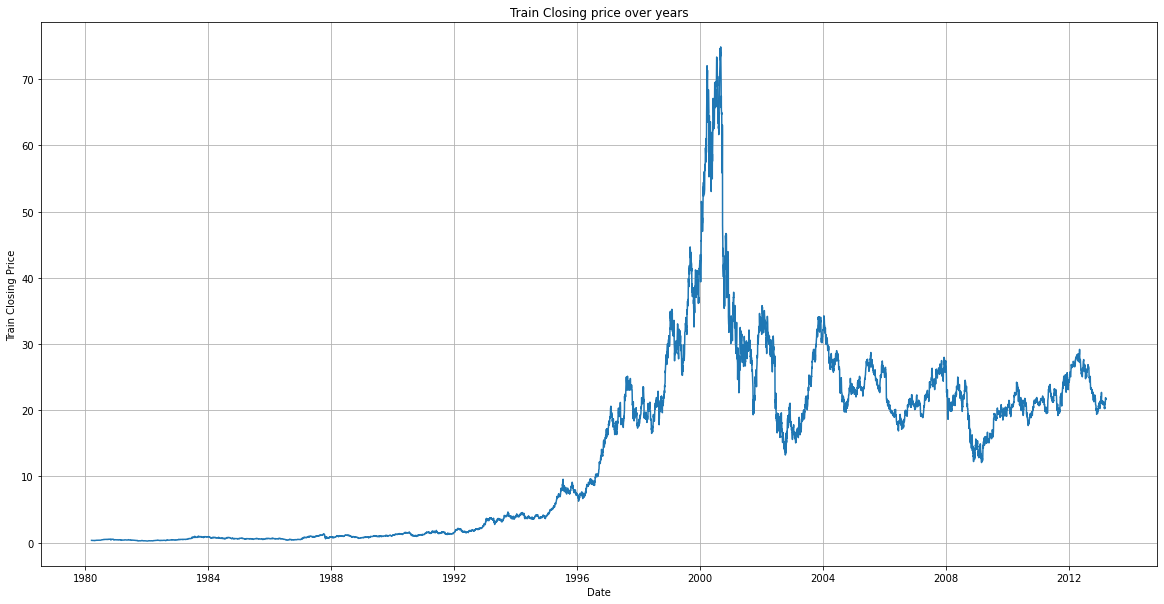

In [ ]:
#Plot the closing price over years
#Train set
plt.figure(figsize=[20,10])
plt.plot(ticker_date_DS[:trainsplit], ticker_train_DS)
plt.title("Train Closing price over years")
plt.ylabel("Train Closing Price")
plt.xlabel("Date")
plt.grid()

In [ ]:
#Define Scaler
scaler = MinMaxScaler(feature_range=(-1,1))

In [ ]:
ticker_train_DS = np.array(ticker_train_DS)
#ticker_train_DS # Train Data Set As Array

ticker_train_DS = np. reshape(ticker_train_DS, (-1,1))
#ticker_train_DS #Train Data Set - Reshaped

ticker_train_DS = scaler.fit_transform(ticker_train_DS)
#Scaled between -1 and 1

In [ ]:
pastDays = 100 #days taken into consideration when making predictions

xtrain = []
ytrain = []

for i in range(pastDays, len(ticker_train_DS)):
  xtrain.append(ticker_train_DS[i-pastDays:i,0])
  ytrain.append(ticker_train_DS[i,0])

xtrain, ytrain = np.array(xtrain), np.array(ytrain)
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1],1))

In [ ]:
#Build the LSTM model
no_neurons = 32
no_epochs = 100

from keras.callbacks import EarlyStopping
ES = EarlyStopping(monitor = "loss", mode='min', patience=3)

model = Sequential()
model.add(LSTM(no_neurons, return_sequences=True, input_shape=(xtrain.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(no_neurons, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(no_neurons, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(no_neurons, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(no_neurons, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(no_neurons, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(no_neurons, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(no_neurons))
model.add(Dense(units=1))
model.compile(optimizer="Adam", loss='mse', metrics=['mean_absolute_error'])
model_history = model.fit(xtrain,ytrain, epochs=no_epochs,callbacks=[ES])

Epoch 1/100
257/257 [==============================] - 25s 35ms/step - loss: 0.0226 - mean_absolute_error: 0.0841
Epoch 2/100
257/257 [==============================] - 9s 35ms/step - loss: 0.0051 - mean_absolute_error: 0.0449
Epoch 3/100
257/257 [==============================] - 9s 34ms/step - loss: 0.0039 - mean_absolute_error: 0.0391
Epoch 4/100
257/257 [==============================] - 9s 34ms/step - loss: 0.0030 - mean_absolute_error: 0.0356
Epoch 5/100
257/257 [==============================] - 9s 34ms/step - loss: 0.0025 - mean_absolute_error: 0.0321
Epoch 6/100
257/257 [==============================] - 9s 34ms/step - loss: 0.0024 - mean_absolute_error: 0.0311
Epoch 7/100
257/257 [==============================] - 9s 34ms/step - loss: 0.0021 - mean_absolute_error: 0.0295
Epoch 8/100
257/257 [==============================] - 9s 34ms/step - loss: 0.0019 - mean_absolute_error: 0.0281
Epoch 9/100
257/257 [==============================] - 9s 33ms/step - loss: 0.0019 - mean_absol

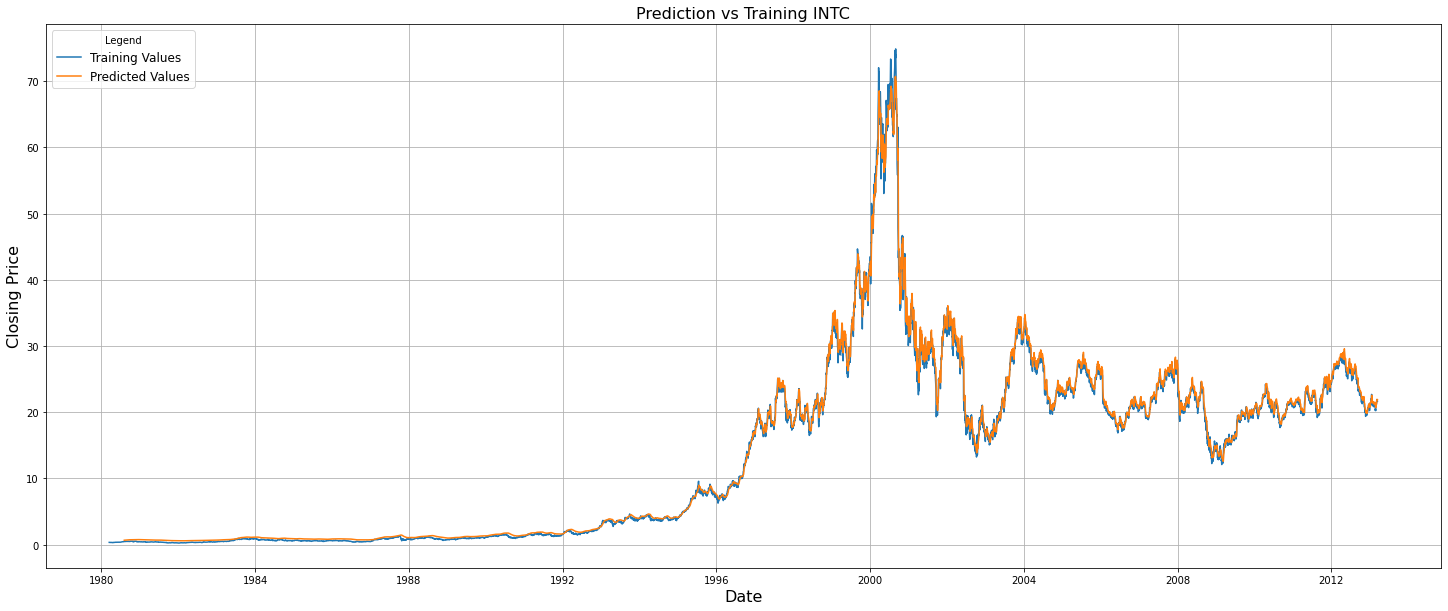

In [ ]:
# Model performance on training set
train_predict = model.predict(xtrain)
plt.figure(figsize=[25,10])
plt.plot(ticker_date_DS[:trainsplit],scaler.inverse_transform(ticker_train_DS), label='Training Values')
plt.plot(ticker_date_DS[100:trainsplit],scaler.inverse_transform(train_predict), label='Predicted Values')
plt.title("Prediction vs Training " +ticker, fontsize=16)
plt.ylabel("Closing Price", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.legend(loc="upper left", title="Legend", frameon=True, fontsize='large')
plt.grid()
plt.show()

In [ ]:
#Using the 80/20(train/test) split, the test set is 20% of the whole closing prices data set

ticker_test_DS = yf.download(ticker, start= ticker_train_date, end='2021-06-16')
ticker_test_DS = ticker_test_DS.reset_index()['Close'].values
ticker_inv_test_DS = scaler.fit_transform(np.array(ticker_test_DS).reshape(-1,1))

[*********************100%***********************]  1 of 1 completed


In [ ]:
#Build x,y test dataset function
xtest = []
ytest = []

for i in range(pastDays, len(ticker_inv_test_DS)):
 xtest.append(ticker_inv_test_DS[i-pastDays:i,0])
 ytest.append(ticker_inv_test_DS[i,0])

xtest, ytest = np.array(xtest), np.array(ytest)
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1],1))

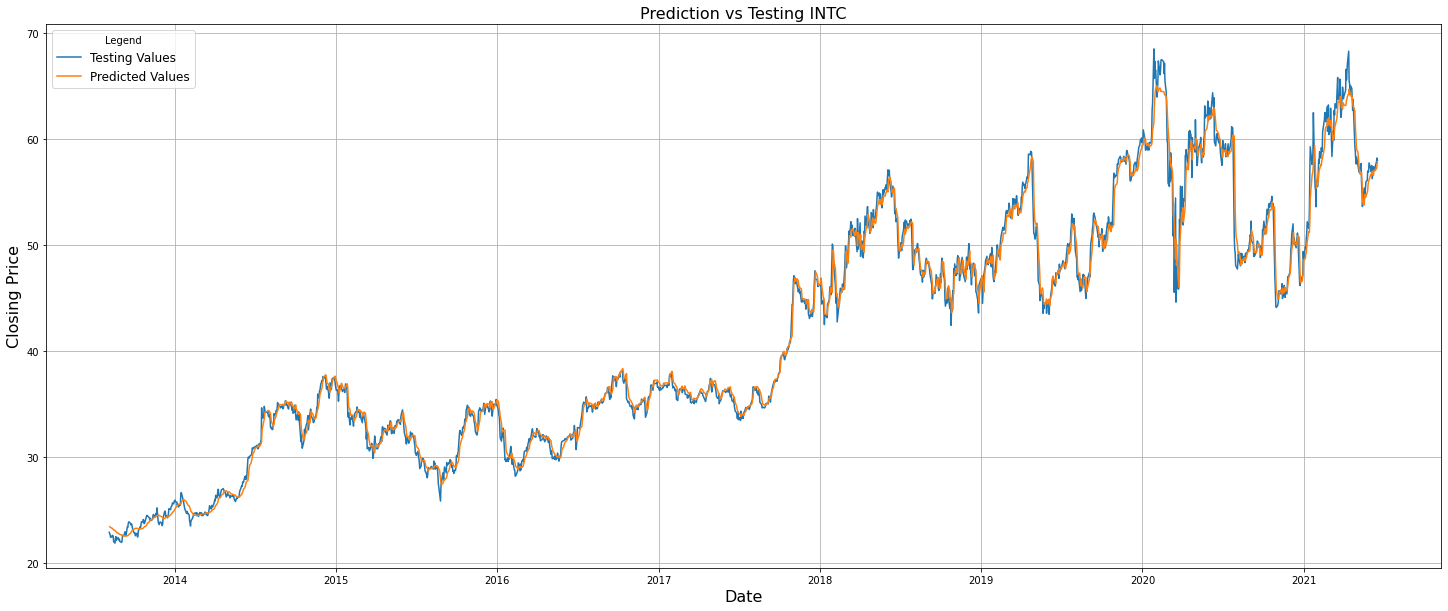

In [ ]:
#Make prediction on the test data set
predictedPrices_test= model.predict(xtest)

#Inverse transform the data so it will show actual prices
predictedPrices_test = scaler.inverse_transform(predictedPrices_test)
#Plot the test data set and the predictions made on it

plt.figure(figsize=[25,10])
plt.plot(ticker_date_DS[trainsplit+100:],ticker_test_DS[99:], label='Testing Values')
plt.plot(ticker_date_DS[trainsplit+pastDays+1:],predictedPrices_test, label='Predicted Values')
plt.title("Prediction vs Testing " +ticker, fontsize=16)
plt.ylabel("Closing Price", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.legend(loc="upper left", title="Legend", frameon=True, fontsize='large')
plt.grid()
plt.show()

In [ ]:
#Testing set vs predictions on testing set accuracy
accuracyMeter(ticker_test_DS[100:], predictedPrices_test)

Test vs Prediction accuracy: 98.33


In [ ]:
#Compute Variance and Bias
variance = np.var(predictedPrices_test)


#sse = sum of squared errors
sse = np.mean((np.mean(predictedPrices_test)-ticker_test_DS)** 2)
bias = sse - variance
print("Variance",variance)
print("Bias:",bias)

Variance 126.58631
Bias: 13.440252783869965


In [ ]:
#Testing predictFutureDays function

#ticker_test_DS = pdr.DataReader("INTC", 'yahoo', ticker_train_date, dt.datetime(2021, 6, 16))
#ticker_test_DS = ticker_test_DS.reset_index()['Close'].values

new_ticker_test_DS = ticker_test_DS[:1980]
new_ticker_test_DS = np.reshape(new_ticker_test_DS, (-1,1))
new_ticker_test_DS_inv = scaler.fit_transform(new_ticker_test_DS)

In [ ]:
#Build new set for future predictions
new_xtest = []
new_ytest = []
for i in range(pastDays, len(new_ticker_test_DS_inv)):
  new_xtest.append(new_ticker_test_DS_inv[i-pastDays:i,0])
  new_ytest.append(new_ticker_test_DS_inv[i,0])

new_xtest, new_ytest = np.array(new_xtest), np.array(new_ytest)
new_xtest = np.reshape(new_xtest, (new_xtest.shape[0], new_xtest.shape[1],1))

In [ ]:
oneDayAhead = predictFutureDays(new_ticker_test_DS,1,model)
true_oneDayAhead = ticker_test_DS[1981]
accuracy = 100 - (100*abs((true_oneDayAhead-oneDayAhead)/true_oneDayAhead)).mean()
print("True value: ", true_oneDayAhead, "Predicted value: ", float(oneDayAhead))
print("Test vs Prediction accuracy:", round(accuracy, 2))

True value:  55.209999084472656 Predicted value:  58.804130795615045
Test vs Prediction accuracy: 93.49


In [ ]:
twoDaysAhead = predictFutureDays(new_ticker_test_DS, 2, model)
true_twoDaysAhead = ticker_test_DS[1981:1983]
print("True value: ", true_twoDaysAhead, "\nPredicted value: ", twoDaysAhead)
accuracyMeter(true_twoDaysAhead, twoDaysAhead)

True value:  [55.20999908 53.59000015] 
Predicted value:  [[58.8041308 ]
 [58.91298195]]
Test vs Prediction accuracy: 91.78


In [ ]:
fDA = predictFutureDays(new_ticker_test_DS, 5, model)
true_fDA = ticker_test_DS[1981:1986]
print("True value: ", true_fDA, "\nPredicted value: ", fDA)
accuracyMeter(true_fDA, fDA)

True value:  [55.20999908 53.59000015 56.06999969 55.50999832 56.68999863] 
Predicted value:  [[58.8041308 ]
 [58.91298195]
 [59.08601462]
 [59.21268015]
 [59.27588987]]
Test vs Prediction accuracy: 93.39


Test vs Prediction accuracy: 93.61


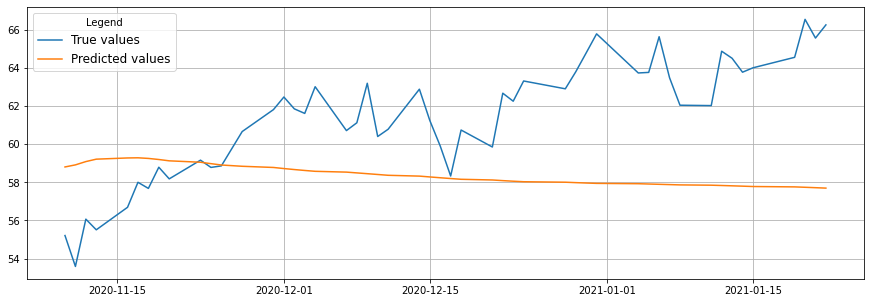

In [ ]:
fifty_DA = predictFutureDays(new_ticker_test_DS, 50, model)
true_fifty_DA = ticker_test_DS[1981:2031]
accuracyMeter(true_fifty_DA, fifty_DA)
plt.figure(figsize=[15,5])
plt.plot(ticker_date_DS[10252:10302],true_fifty_DA, label='True values')
plt.plot(ticker_date_DS[10252:10302],fifty_DA, label='Predicted values')
plt.legend(loc="upper left", title="Legend", frameon=True, fontsize='large')
plt.grid()

Test vs Prediction accuracy: 94.75


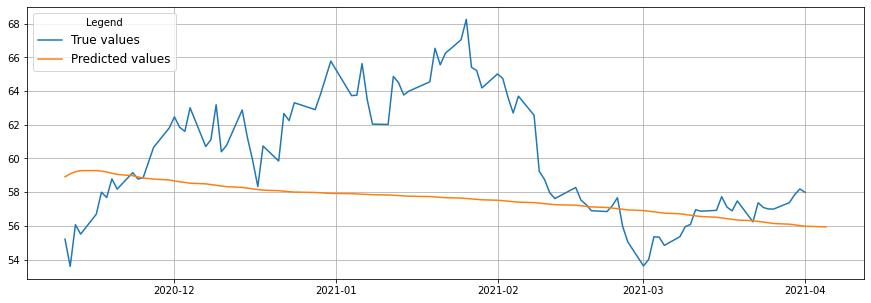

In [ ]:
oneh_DA = predictFutureDays(new_ticker_test_DS, 100, model)
true_oneh_DA = ticker_test_DS[1981:2081]
accuracyMeter(true_oneh_DA, oneh_DA)
plt.figure(figsize=[15,5])
plt.plot(ticker_date_DS[10252:10350], true_oneh_DA, label='True values')
plt.plot(ticker_date_DS[10252:10351], oneh_DA, label='Predicted values')
plt.legend(loc="upper left", title="Legend", frameon=True, fontsize='large')
plt.grid()

In [ ]:
############################# UNIVERSAL PREDICTOR #################################################################

Company Ticker Symbol:  AAPL
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/100
253/253 [==============================] - 18s 34ms/step - loss: 0.0242 - mean_absolute_error: 0.0794
Epoch 2/100
253/253 [==============================] - 8s 33ms/step - loss: 0.0030 - mean_absolute_error: 0.0356
Epoch 3/100
253/253 [==============================] - 9s 34ms/step - loss: 0.0020 - mean_absolute_error: 0.0278
Epoch 4/100
253/253 [==============================] - 9s 34ms/step - loss: 0.0019 - mean_absolute_error: 0.0263
Epoch 5/100
253/253 [==============================] - 9s 34ms/step - loss: 0.0016 - mean_absolute_error: 0.0245
Epoch 6/100
253/253 [==============================] - 9s 34ms/step - loss: 0.0015 - mean_absolute_error: 0.0239
Epoch 7/100
253/253 [==============================] - 9s 34ms/step - loss: 0.0014 - 

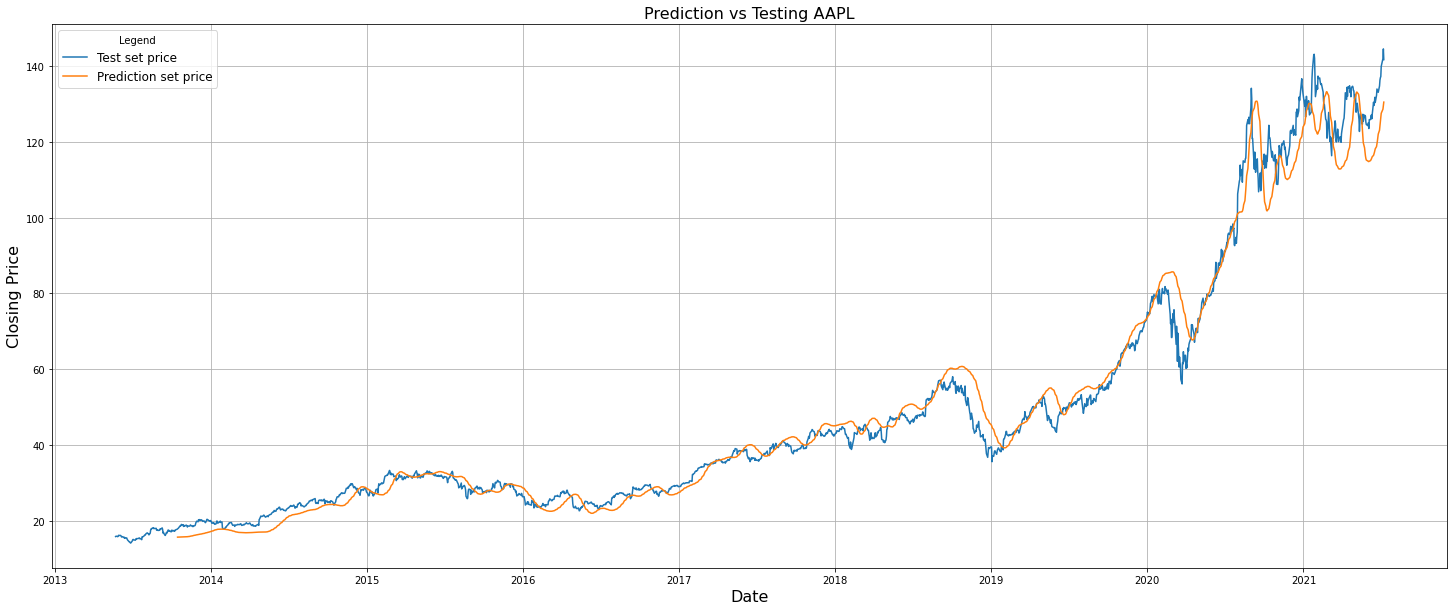

In [ ]:
# Make sure you have the ticker symbol of the company and the starting date of the prices.
##Step 1 - Use the companyDS function in order to gather the train, test and date data sets. Careful: it will return the train, test, date in this order!
new_ticker = "AAPL"
new_startDate = dt.date(1900,1,1)
new_train, new_test, new_date = companyDS(new_ticker, new_startDate)

##Step 2 - Reshape, transform and normalize the sets
new_train = np.array(new_train)
new_train = new_train.reshape(-1,1)
new_inv_train = scaler.fit_transform(new_train)

new_test = np.array(new_test)
new_test = new_test.reshape(-1,1)
new_inv_test = scaler.fit_transform(new_test)

##Step 3 - Build training set
pastDays = 100
new_x_train, new_y_train = trainBuild(new_inv_train)

##Step 4 - Train the model
#Build and train the LSTM model
no_neurons = 32
no_epochs = 100
new_model = build_model(no_neurons, no_epochs, new_x_train, new_y_train)

##Step 5 - Build the test sets for the LSTM with the trainBuild and testBuild
new_x_test, new_y_test = testBuild(new_inv_test)

##Step 6 - Predict on the sets
new_pred = new_model.predict(new_x_test)

##Step 7 - Plot the figure using the plotPredictions function. You will need to pass the test(not inversed), predictions and date sets!
plotPredictions(new_test, new_pred, new_date, new_ticker)

In [ ]:
#Get the actual values of the predictions
new_pred = scaler.inverse_transform(new_pred)

In [ ]:
#Test accuracy
accuracyMeter(new_test[100:], new_pred)

Test vs Prediction accuracy: 93.2


In [ ]:
  ################################################# EXPERIMENT -  Random Sets ##############################################################

In [ ]:
#Build closing price set for the histogram plot
ticker_close_DS = yf.download(ticker, start=startDate, end='2021-06-16')
ticker_close_DS = ticker_close_DS.reset_index()['Close']

#Compute the change between consecutive prices
change = []
change_serie = []

for i in range(1, len(ticker_close_DS)):
  change = ticker_close_DS[i] - ticker_close_DS[i-1]
  change_serie = np.append(change_serie, change)

[*********************100%***********************]  1 of 1 completed


In [ ]:
#Transform to Series type
change_serie = pd.Series(change_serie)

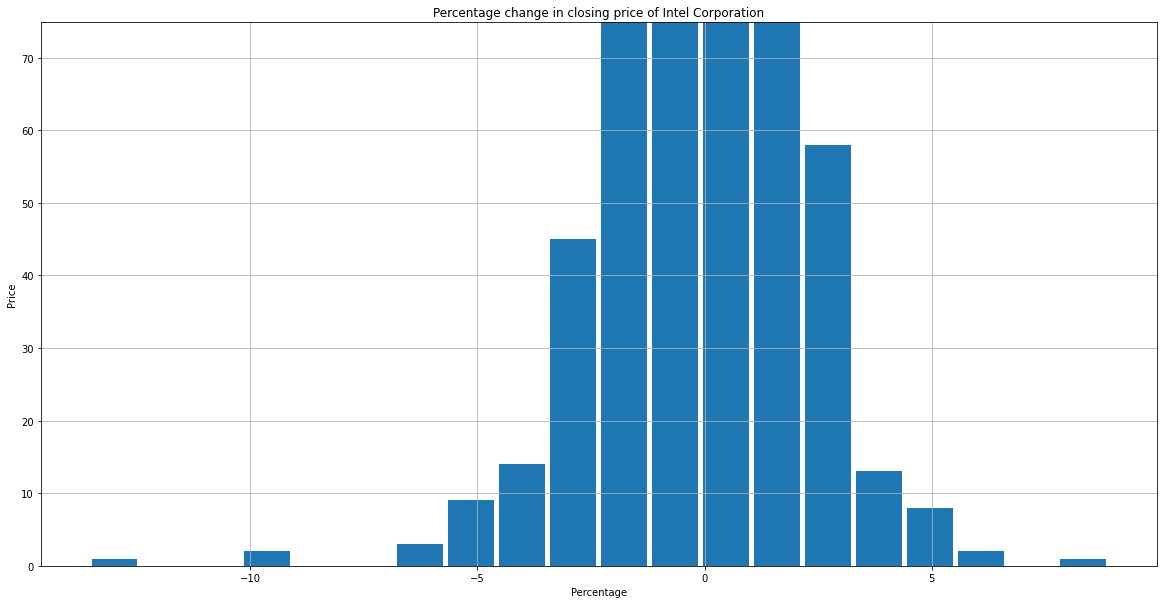

In [ ]:
#Plot Histogram
plt.figure(figsize=[20,10])
hist = change_serie.plot.hist(grid=True, bins=20, rwidth=0.9)
plt.title("Percentage change in closing price of Intel Corporation")
plt.xlabel("Percentage")
plt.ylabel("Price")
plt.ylim(ymax = ticker_close_DS.max())
plt.show()

In [ ]:
#Random Set Creator
rand_start_price = np.random.randint(0,100)
rand_start_price_equal = rand_start_price / 10
r1 = np.random.randint(2, size=len(ticker_date_DS))
r2 = np.random.randint(2, size=len(ticker_date_DS))
rand_set = []

for i in range(len(ticker_date_DS)):
  if r1[i] > r2[i] :
    rand_start_price += (rand_start_price/10)
    rand_set = np.append(rand_set, rand_start_price)
  elif r1[i] < r2[i]:
    rand_start_price -= (rand_start_price/10)
    rand_set = np.append(rand_set, rand_start_price)
  elif r1[i]==r2[i]:
    rand_start_price += rand_start_price_equal
    rand_set = np.append(rand_set, rand_start_price)

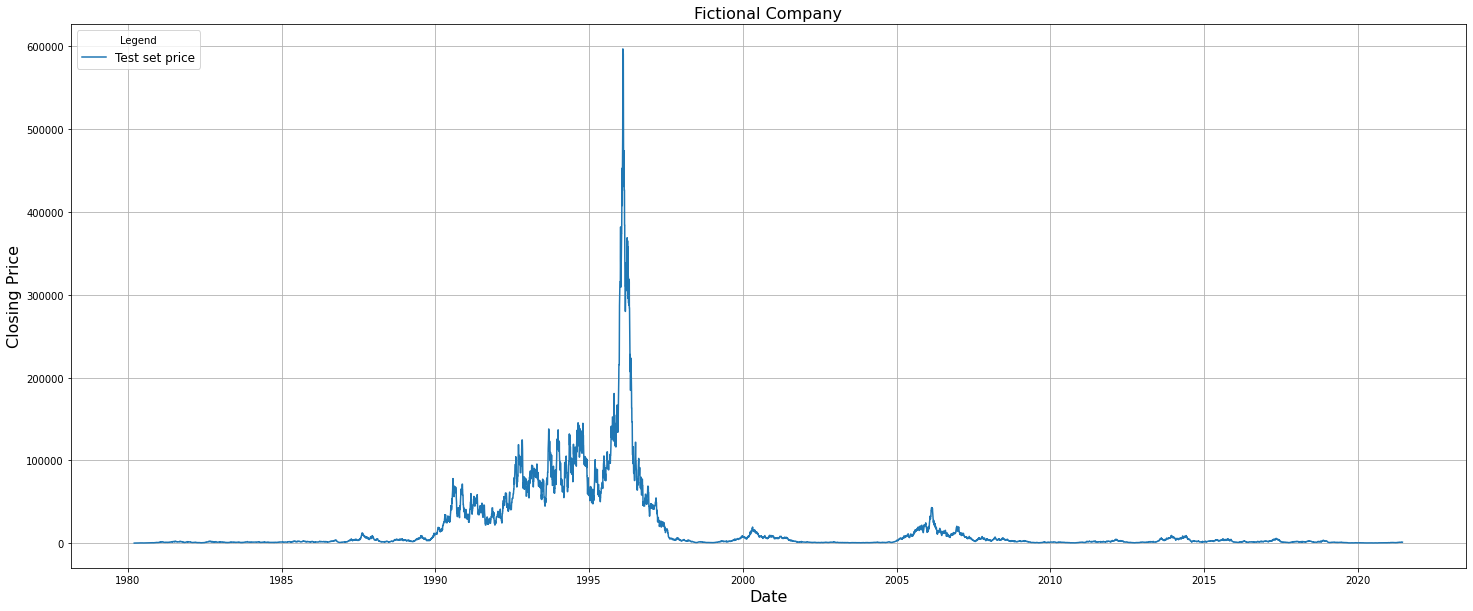

In [ ]:
#Plot Random Set
plt.figure(figsize=[25,10])
plt.plot(ticker_date_DS, rand_set, label='Test set price')
plt.title("Fictional Company", fontsize=16)
plt.ylabel("Closing Price", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.legend(loc="upper left", title="Legend", frameon=True, fontsize='large')
plt.grid()
plt.show()

In [ ]:
#Split the training part
rand_set_len = len(rand_set)
trainsplit = 0.8 * rand_set_len
trainsplit = int(round(trainsplit,0))

rand_set_date = ticker_date_DS[trainsplit]

In [ ]:
#Process the training set
rand_set_train = rand_set[:trainsplit]
rand_set_train = np.array(rand_set_train)
rand_set_train = rand_set_train.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(-1,1))
rand_set_train_inv = scaler.fit_transform(rand_set_train)

In [ ]:
#Build training set
pastDays = 100
rand_x, rand_y = trainBuild(rand_set_train_inv)

In [ ]:
#Build model based on random set
rand_model = build_model(32, 100, rand_x, rand_y)

Epoch 1/100
257/257 [==============================] - 18s 35ms/step - loss: 0.0278 - mean_absolute_error: 0.0893
Epoch 2/100
257/257 [==============================] - 9s 34ms/step - loss: 0.0040 - mean_absolute_error: 0.0390
Epoch 3/100
257/257 [==============================] - 9s 34ms/step - loss: 0.0031 - mean_absolute_error: 0.0333
Epoch 4/100
257/257 [==============================] - 9s 34ms/step - loss: 0.0025 - mean_absolute_error: 0.0288
Epoch 5/100
257/257 [==============================] - 9s 34ms/step - loss: 0.0021 - mean_absolute_error: 0.0264
Epoch 6/100
257/257 [==============================] - 9s 34ms/step - loss: 0.0020 - mean_absolute_error: 0.0264
Epoch 7/100
257/257 [==============================] - 9s 34ms/step - loss: 0.0020 - mean_absolute_error: 0.0261
Epoch 8/100
257/257 [==============================] - 9s 33ms/step - loss: 0.0017 - mean_absolute_error: 0.0244
Epoch 9/100
257/257 [==============================] - 9s 34ms/step - loss: 0.0018 - mean_absol

In [ ]:
#Process testing set
rand_set_test = rand_set[trainsplit:]
rand_set_test = np.array(rand_set_test)
rand_set_test = rand_set_test.reshape(-1,1)
rand_set_test_inv = scaler.fit_transform(rand_set_test)

In [ ]:
#Build testing set
rand_x_test, rand_y_test = testBuild(rand_set_test_inv)

In [ ]:
#Predict on random testing set
rand_predictions = rand_model.predict(rand_x_test)

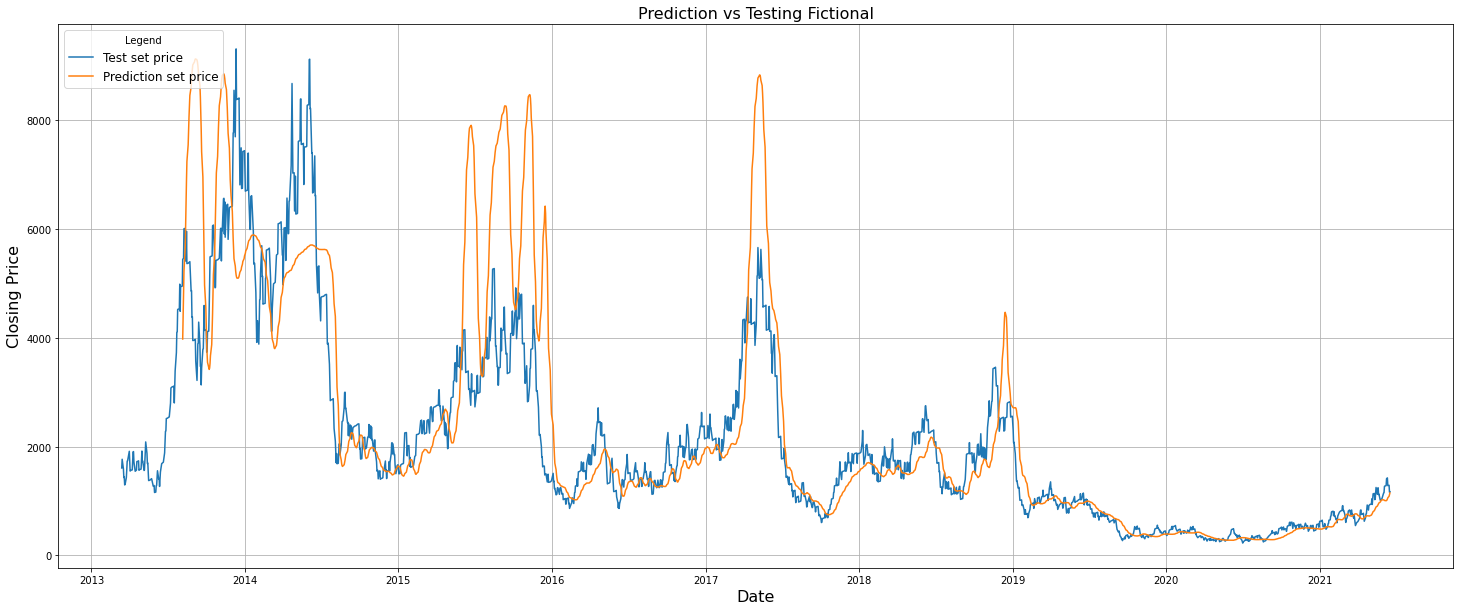

In [ ]:
#Plot True values vs Predicted ones
plotPredictions(rand_set_test, rand_predictions, ticker_date_DS, "Fictional")

In [ ]:
#Model created with random values predicts on intel Testing set
new_xtest_intc, new_ytest_intc = testBuild(ticker_inv_test_DS)
rand_pred_intc = rand_model.predict(new_xtest_intc)
rand_pred_intc = scaler.inverse_transform(rand_pred_intc)

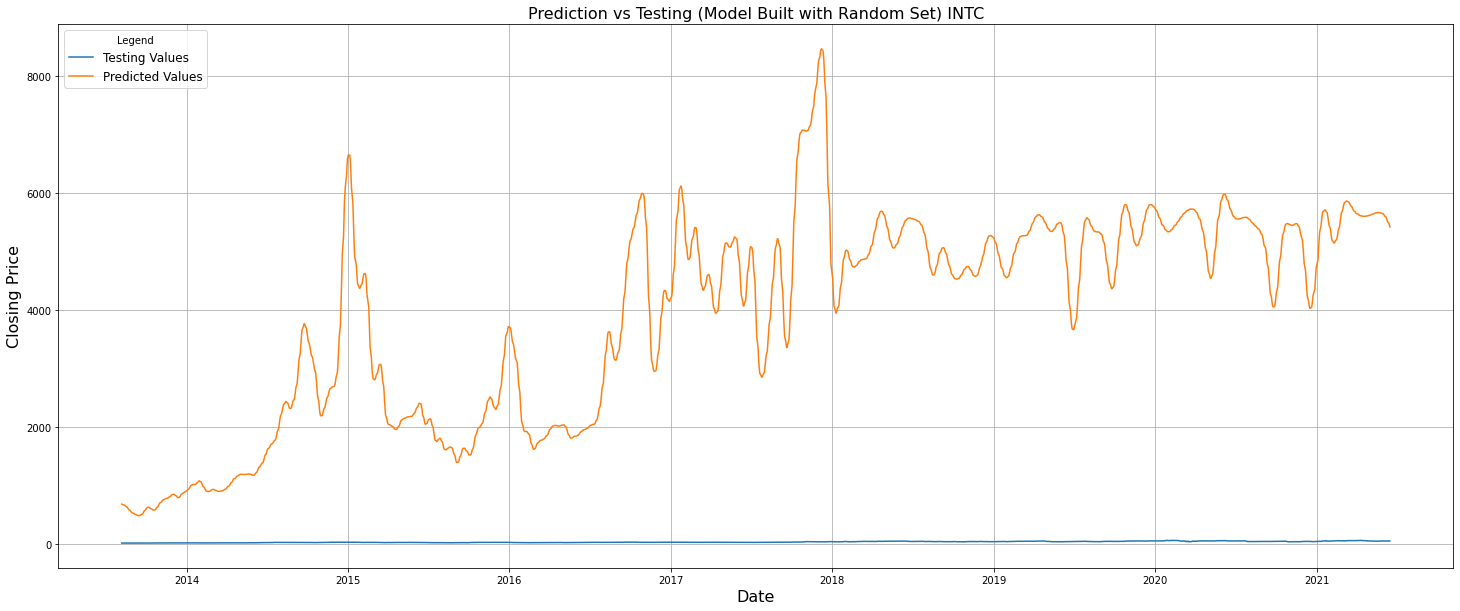

In [ ]:
#Plotting model performance trained on random set predicting on Intel testing set 
plt.figure(figsize=[25,10])
plt.plot(ticker_date_DS[-1979:], ticker_test_DS[pastDays:], label='Testing Values')
plt.plot(ticker_date_DS[-1979:], rand_pred_intc, label='Predicted Values')
plt.title("Prediction vs Testing (Model Built with Random Set) " +ticker, fontsize=16)
plt.ylabel("Closing Price", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.legend(loc="upper left", title="Legend", frameon=True, fontsize='large')
plt.grid()
plt.show()


In [ ]:
oneDayAhead = predictFutureDays(ticker_test_DS,1,rand_model)
true_oneDayAhead = ticker_test_DS[1981]
accuracy = 100 - (100*abs((true_oneDayAhead-oneDayAhead)/true_oneDayAhead)).mean()
print("True value: ", true_oneDayAhead, "Predicted value: ", float(oneDayAhead))
print("Test vs Prediction accuracy:", round(accuracy, 2))

True value:  55.209999084472656 Predicted value:  56.39153485628913
Test vs Prediction accuracy: 97.86


In [ ]:
twoDaysAhead = predictFutureDays(ticker_test_DS, 2, rand_model)
true_twoDaysAhead = ticker_test_DS[1981:1983]
print("True value: ", true_twoDaysAhead, "\nPredicted value: ", twoDaysAhead)
accuracyMeter(true_twoDaysAhead, twoDaysAhead)

True value:  [55.20999908 53.59000015] 
Predicted value:  [[56.39153486]
 [56.33288883]]
Test vs Prediction accuracy: 96.37


In [ ]:
fDA = predictFutureDays(ticker_test_DS, 5, rand_model)
true_fDA = ticker_test_DS[1981:1986]
print("True value: ", true_fDA, "\nPredicted value: ", fDA)
accuracyMeter(true_fDA, fDA)

True value:  [55.20999908 53.59000015 56.06999969 55.50999832 56.68999863] 
Predicted value:  [[56.39153486]
 [56.33288883]
 [56.30000876]
 [56.29573862]
 [56.31500735]]
Test vs Prediction accuracy: 98.05


Test vs Prediction accuracy: 91.01


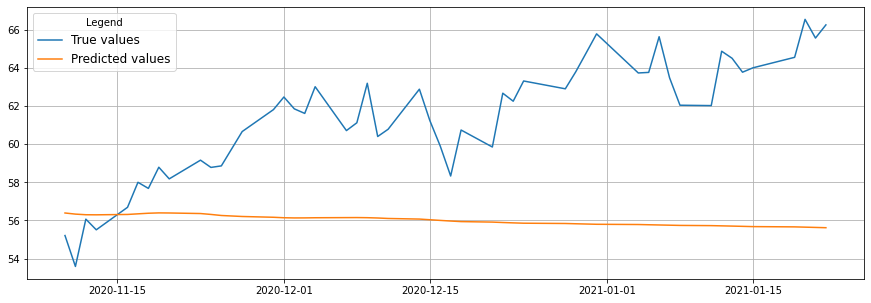

In [ ]:
fifty_DA = predictFutureDays(ticker_test_DS, 50, rand_model)
true_fifty_DA = ticker_test_DS[1981:2031]
accuracyMeter(true_fifty_DA, fifty_DA)
plt.figure(figsize=[15,5])
plt.plot(ticker_date_DS[10252:10302],true_fifty_DA, label='True values')
plt.plot(ticker_date_DS[10252:10302],fifty_DA, label='Predicted values')
plt.legend(loc="upper left", title="Legend", frameon=True, fontsize='large')
plt.grid()

Test vs Prediction accuracy: 92.65


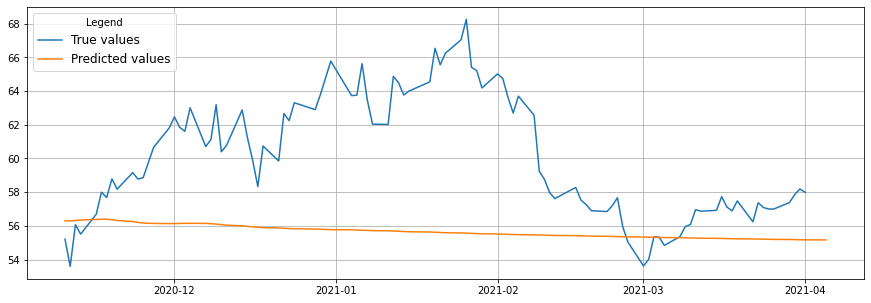

In [ ]:
oneh_DA = predictFutureDays(ticker_test_DS, 101, rand_model)
true_oneh_DA = ticker_test_DS[1981:2081]
accuracyMeter(true_oneh_DA, oneh_DA)
plt.figure(figsize=[15,5])
plt.plot(ticker_date_DS[10252:10350], true_oneh_DA, label='True values')
plt.plot(ticker_date_DS[10252:10351], oneh_DA, label='Predicted values')
plt.legend(loc="upper left", title="Legend", frameon=True, fontsize='large')
plt.grid()

In [ ]:
########## 3.6 FUTURE MONTH PREDICTIONS ##########

In [ ]:
#Because from 17 june to 16 july there are 22 days
#we will predict 22 days in the future with the predictFutureDays function
futureDays = predictFutureDays(ticker_test_DS, 22, model)

In [ ]:
#Build date sets for future month
#Weekends excluded
futureDates = pd.date_range(start="2021-06-17",end="2021-06-18", freq='D')
futureDates1 = pd.date_range(start="2021-06-21",end="2021-06-25", freq='D')
futureDates2 = pd.date_range(start="2021-06-28",end="2021-07-02", freq='D')
futureDates3 = pd.date_range(start="2021-07-05",end="2021-07-09", freq='D')
futureDates4 = pd.date_range(start="2021-07-12",end="2021-07-16", freq='D')
futureDates = futureDates.append(futureDates1)
futureDates = futureDates.append(futureDates2)
futureDates = futureDates.append(futureDates3)
futureDates = futureDates.append(futureDates4)
futureDates

DatetimeIndex(['2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22',
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28',
               '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02',
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16'],
              dtype='datetime64[ns]', freq=None)

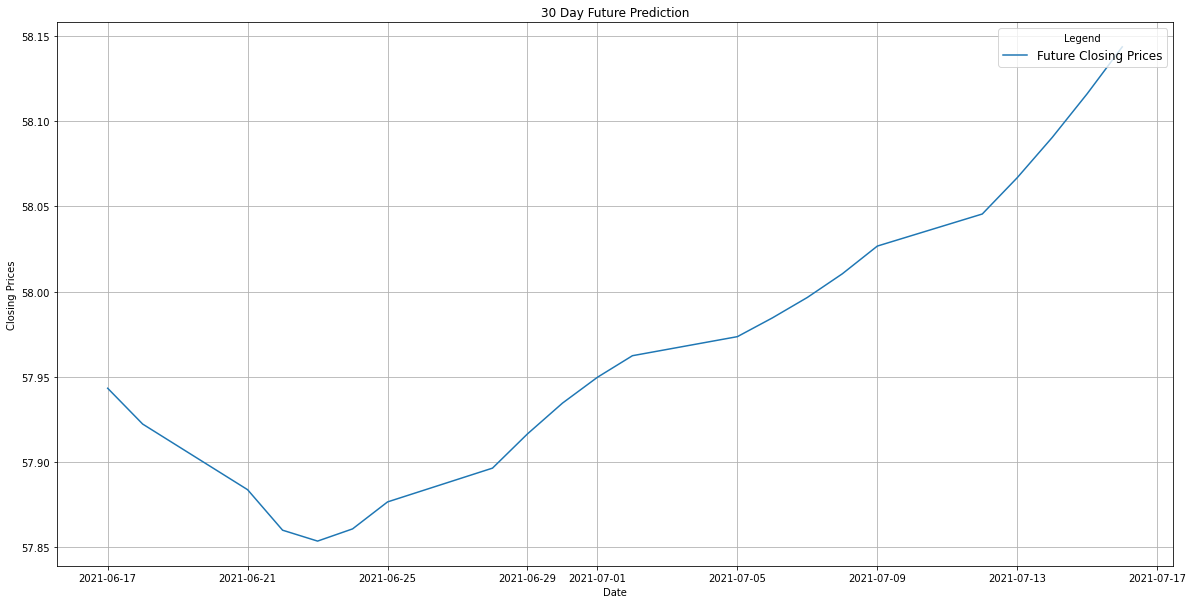

In [ ]:
#Plot future predictions
plt.figure(figsize=[20,10])
plt.plot(futureDates, futureDays, label="Future Closing Prices")
plt.title("30 Day Future Prediction")
plt.legend(loc="upper right", title="Legend", frameon=True, fontsize='large')
plt.ylabel("Closing Prices")
plt.xlabel("Date")
plt.grid()
plt.show()

In [ ]:
#Build comparison test set with latest 12 values
ticker_test_full_DS = yf.download(ticker, start=ticker_train_date, end='2021-07-02')
comparison_test = ticker_test_full_DS[-12:]
comparison_test = comparison_test.reset_index()['Close']


[*********************100%***********************]  1 of 1 completed


In [ ]:
#Build comparison test date set
comparison_test_date = futureDates[:12]

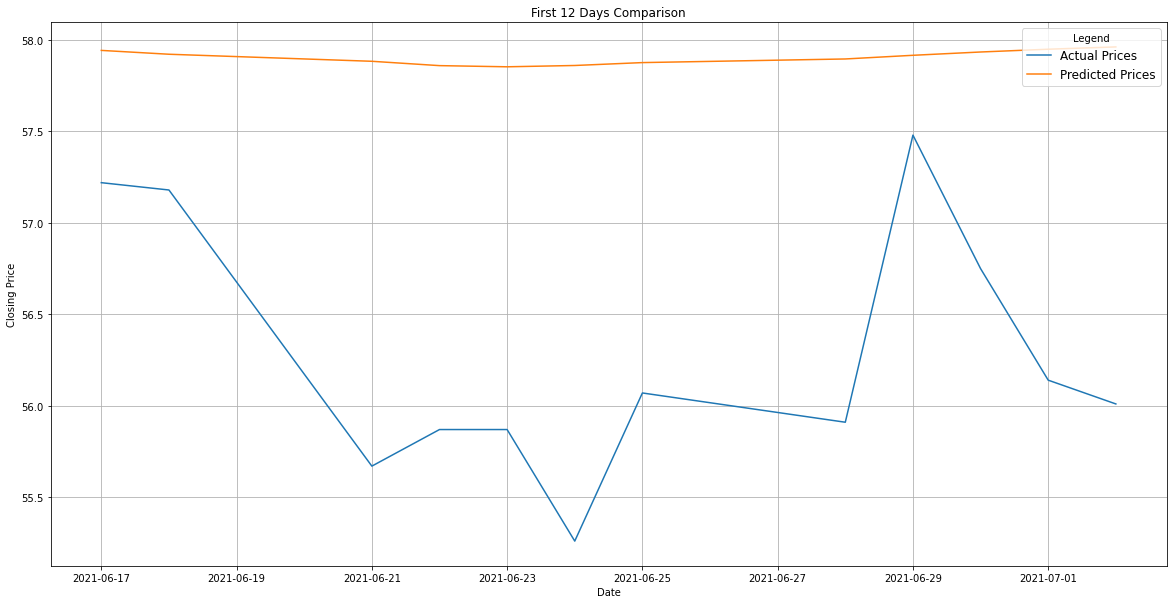

In [ ]:
#Plot first 12 days performance
plt.figure(figsize=[20,10])
plt.plot(comparison_test_date, comparison_test, label='Actual Prices')
plt.plot(comparison_test_date, futureDays[:12], label='Predicted Prices')
plt.title("First 12 Days Comparison")
plt.ylabel("Closing Price")
plt.xlabel("Date")
plt.legend(loc="upper right", title="Legend", frameon=True, fontsize='large')
plt.grid()
plt.show()

In [ ]:
#Build sets to measure accuracy
true_test = ticker_test_full_DS[-12:]
true_test = true_test.reset_index()['Close']
true_test = np.reshape(np.array(true_test), (-1,1))
pred_test = futureDays[:12]

In [ ]:
#Measure accuracy between predictions and true values
accuracyMeter(true_test, pred_test)

Test vs Prediction accuracy: 97.11


In [ ]:
########## Chapter 4 - Conclusion #########
real_prices = np.append(new_ticker_test_DS, oneh_DA)
real_prices.shape

(2079,)

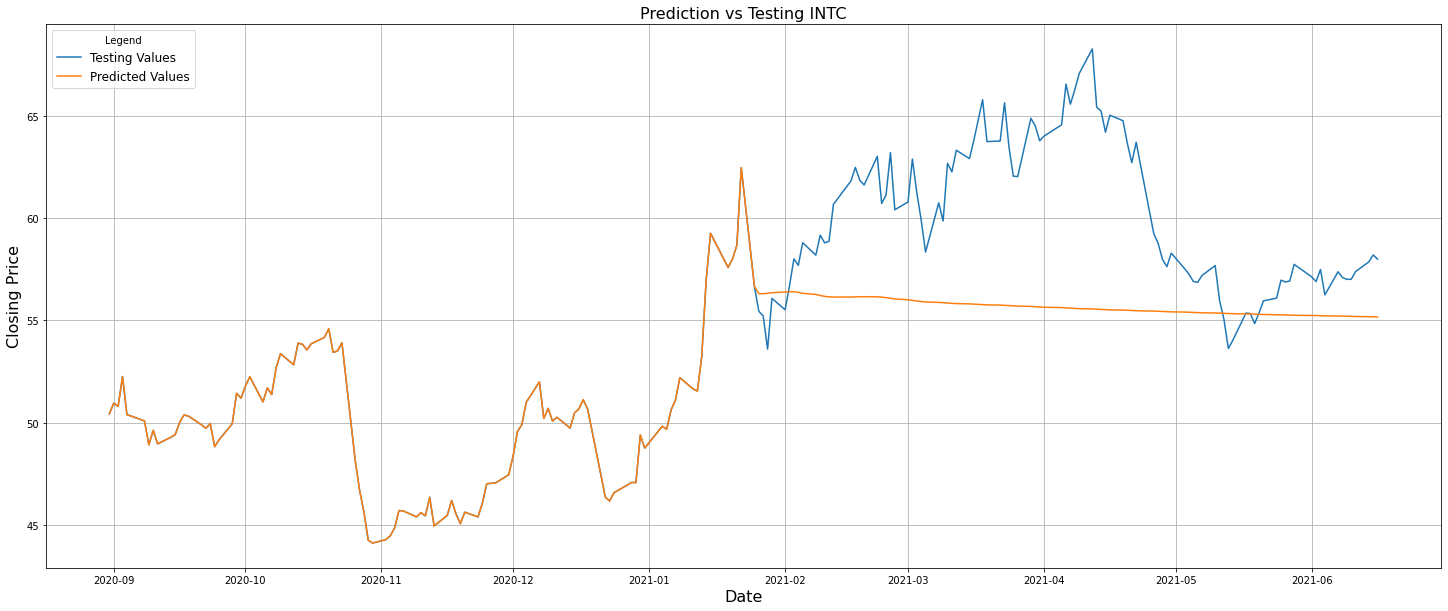

In [ ]:
########## Chapter 4 - Conclusion #########
plt.figure(figsize=[25,10])
plt.plot(ticker_date_DS[-200:],ticker_test_DS[-200:], label='Testing Values')
plt.plot(ticker_date_DS[-200:],real_prices[-200:], label='Predicted Values')
plt.title("Prediction vs Testing " +ticker, fontsize=16)
plt.ylabel("Closing Price", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.legend(loc="upper left", title="Legend", frameon=True, fontsize='large')
plt.grid()
plt.show()

In [ ]:
print(time.time() - startTime)

753.1100273132324
